**Efficient Water Quality Analysis and Prediction using Machine Learning**

Machine learning algorithm: Random Forest Classifier

Dataset:[Indian water quality analysis and prediction](https://www.kaggle.com/code/anbarivan/indian-water-quality-analysis-and-prediction/notebook)

# Importing Libraries

In [453]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore

# Importing Dataset

In [454]:
# Importing the dataset
df = pd.read_csv("water_dataX.csv", encoding= 'unicode_escape')


In [455]:
df.shape

(1991, 12)

In [456]:
# Selecting 1900 samples, because samples having indices greater than 1900 are not correct
df = df.iloc[0:1990, :]
df.shape

(1990, 12)

In [457]:
# Checking for datatypes of the dataset
df.dtypes


STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

In [458]:
# Changing column names
df = df.rename(columns={"D.O. (mg/l)": "DO", "CONDUCTIVITY (µmhos/cm)": "Conductivity", "B.O.D. (mg/l)": "BOD", "NITRATENAN N+ NITRITENANN (mg/l)": "NI", "FECAL COLIFORM (MPN/100ml)": "Fec_col", "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

# Coverting the attributes to Numeric Datatype

In [459]:
# Converting object data type to numeric
def convert_to_numeric(df):
    num_col = df.shape[1]
    # Start from index 3
    for index in range(3, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

STATION CODE     object
LOCATIONS        object
STATE            object
Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
year              int64
dtype: object

# Handling missing values

In [460]:
# Replacing string NAN values with actual NAN value (np.nan)
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

In [461]:
# Checking for missing values
df.isnull().sum().sort_values()

year              0
PH                8
Conductivity     25
DO               31
BOD              43
Temp             92
STATION CODE    122
Tot_col         132
LOCATIONS       184
NI              224
Fec_col         315
STATE           760
dtype: int64

In [462]:
# Replacing NULL values with median of column
# Selecting numeric data
df_num = df.select_dtypes(exclude="object")
df_num_col = df_num.columns
imputer = SimpleImputer(strategy="median")

df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

In [463]:
# Filling Categorical missing values
df_cat = df.select_dtypes(include="object")
df_cat.isnull().sum()

STATION CODE    122
LOCATIONS       184
STATE           760
dtype: int64

In [464]:

pd.set_option('mode.chained_assignment', None)
df_cat_copy = df_cat.copy()
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]
df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"] = df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"].fillna("TAMILNADU")
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [465]:
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [466]:
def fill_code(df_cat):
    station_null = df_cat[df_cat["STATION CODE"].isnull()]
    station_null_indices = station_null.index
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_cat_copy)
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [467]:
# Filling all state NAN values which have corresponding station code value
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [468]:
df_cat_copy.isnull().sum()

STATION CODE      5
LOCATIONS       184
STATE            13
dtype: int64

In [469]:
df_cat_copy[df_cat_copy["STATE"].isnull()]

,STATION CODE,LOCATIONS,STATE
260,NaN,NaN,NaN
431,NaN,NaN,NaN
1106,1207,KABBANI AT MUTHANKARA,NaN
1107,1208,BHAVANI AT ELACHIVAZHY,NaN
1650,2047,"NNANCHOE (ATTAWA CHOE), CHANDIGARH",NaN
1651,2048,"PATIALA KI RAO, CHANDIGARH",NaN
1652,2049,"SUKHNA CHOE, CHANDIGARH",NaN
1770,2047,NNANCHOE (ATTAWA CHOE),NaN
1771,2048,PATIALA KI RAO,NaN
1772,2049,SUKHNA CHOE,NaN


In [470]:
# The first location KABBANI AT MUTHANKARA is in STATE Kerela
df_cat_copy["STATE"][1106] = "KERALA"
df_cat_copy["STATE"][1107] = "KERALA"
df_cat_copy["STATE"][1650] = "CHANDIGARH"
df_cat_copy["STATE"][1651] = "CHANDIGARH"
df_cat_copy["STATE"][1652] = "CHANDIGARH"
df_cat_copy["STATE"][1770] = "CHANDIGARH"
df_cat_copy["STATE"][1771] = "CHANDIGARH"
df_cat_copy["STATE"][1772] = "CHANDIGARH"
df_cat_copy["STATE"][1784] = "DAMAN & DIU"
df_cat_copy["STATE"][1785] = "DAMAN & DIU"
df_cat_copy["STATION CODE"][1784] = "0000" # I am setting this according to myself
df_cat_copy["STATION CODE"][1785] = "0000"

In [471]:
df_cat = df_cat_copy
df_cat.isnull().sum()

STATION CODE      3
LOCATIONS       184
STATE             3
dtype: int64

In [472]:
df_num.isnull().sum()

Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [473]:
df_final = pd.concat([df_cat, df_num], axis=1)
df_final.isnull().sum()

STATION CODE      3
LOCATIONS       184
STATE             3
Temp              0
DO                0
PH                0
Conductivity      0
BOD               0
NI                0
Fec_col           0
Tot_col           0
year              0
dtype: int64

In [474]:

# The filled attributes are median of corresponding columns
# So it is best to remove them
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_null

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
260,NaN,NaN,NaN,27.0,6.7,7.3,183.0,1.9,0.516,221.0,467.0,2013.0
431,NaN,NaN,NaN,27.0,6.7,7.3,183.0,1.9,0.516,221.0,467.0,2013.0
1912,NaN,NaN,NaN,27.0,6.7,7.3,183.0,1.9,0.516,221.0,467.0,2003.0


In [475]:
df_final.isnull().sum()

STATION CODE      0
LOCATIONS       181
STATE             0
Temp              0
DO                0
PH                0
Conductivity      0
BOD               0
NI                0
Fec_col           0
Tot_col           0
year              0
dtype: int64

In [476]:
df_final.shape

(1987, 12)

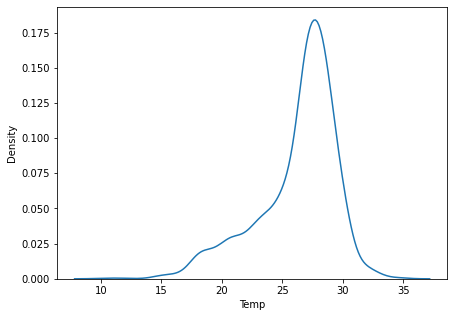

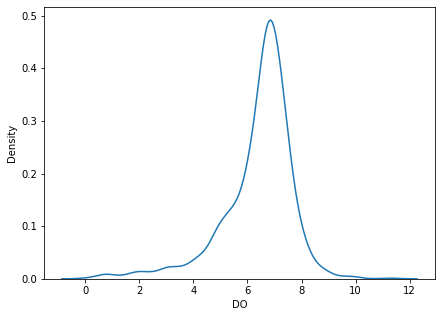

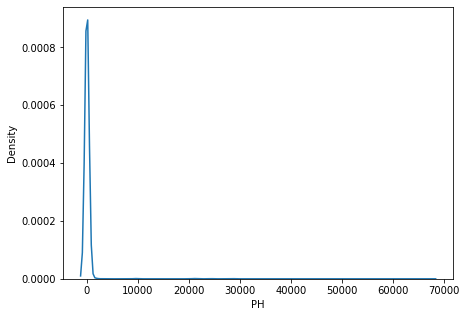

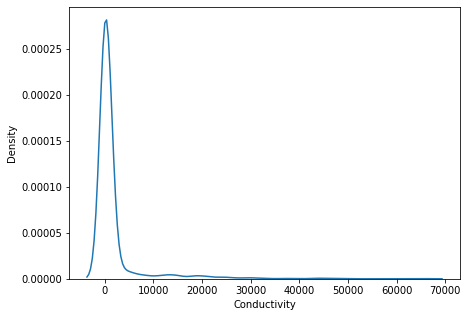

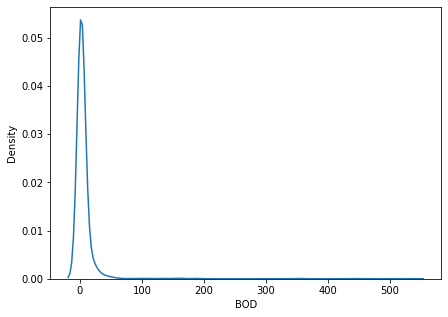

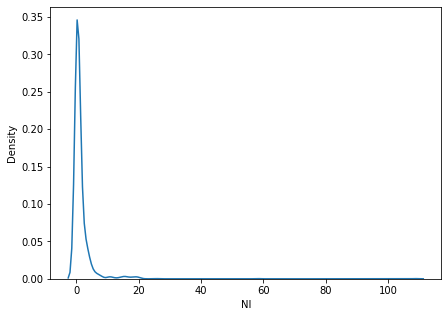

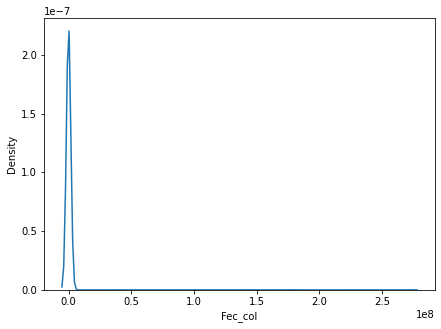

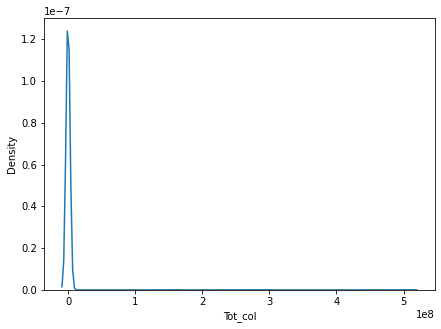

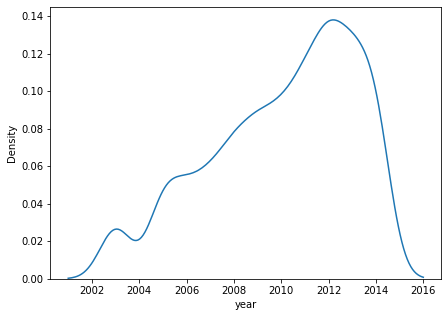

In [477]:
# PLotting PDFs of all the numeric attributes in the dataset

df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

# Handling Outliers and replacing the outliers

In [478]:
# Here, almost all kde plots are Gaussian Like 
# Using Z-Score Normalization to detect outliers

df_num_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
df_final.iloc[indices_arr, :]

Number of outliers using Z-Score method- 139


,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
741,2880,NAMBUL RIVER AT BISHNUPUR,MANIPUR,28.0,8.2,7.6,112.0,2.1,0.516,221.0,31.0,2012.0
745,2856,"THOUBAL RIVER AT YAIRIPOK, THOUBAL",MANIPUR,30.0,9.3,7.6,193.0,2.3,0.516,221.0,41.0,2012.0
1917,1862,RIVER KAVERI ON BRIDGE AT BILLIMORANANVALSAD ROAD,GUJARAT,29.0,8.1,467.0,7.1,3.0,0.516,221.0,107.0,2003.0
1924,1438,"MINDHOLA AT STATE HIGHWAY BRIDGE SACHIN, GUJARAT",GUJARAT,28.0,8.0,590.0,4.8,1.8,0.516,221.0,2873.0,2003.0
1925,1444,"KALI AT D/S WEST COAST PAPER MILL, KARNATAKA",KARNATAKA,27.0,7.7,440.0,6.5,2.4,0.900,0.9,688.0,2003.0
...,...,...,...,...,...,...,...,...,...,...,...,...
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.000,1328.0,4975.0,2013.0
685,1023,GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA),PUNJAB,21.0,5.5,7.4,635.0,8.8,5.080,1400.0,5500.0,2012.0
172,3023,"VASISTA AT SALEM, D/S OF SAGO INDUSRIES EFFLUE...",TAMILNADU,24.3,0.9,7.6,2039.0,104.5,0.900,272521616.0,511090873.0,2014.0
432,1023,"GHAGGAR AT MUBARAKPUR REST HOUSE (PATIALA), PU...",PUNJAB,23.3,5.5,7.2,636.0,9.7,4.000,1328.0,4975.0,2013.0


In [479]:
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1861, 12)

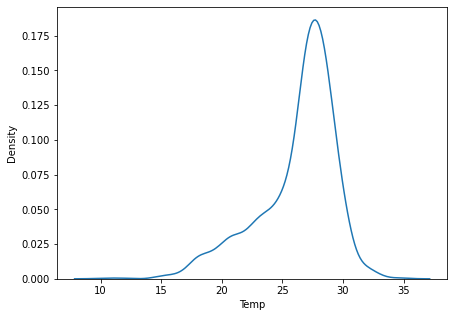

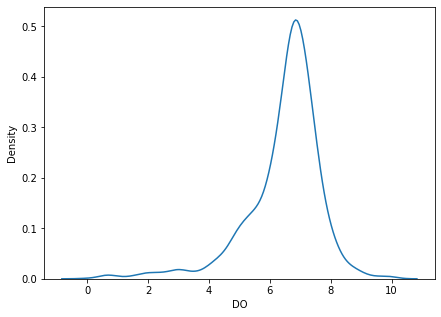

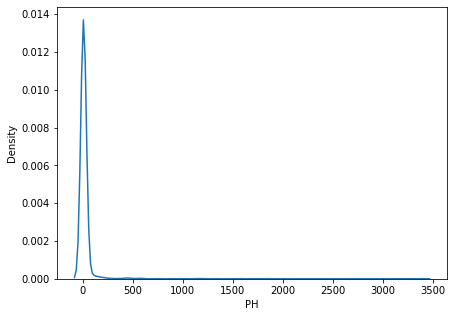

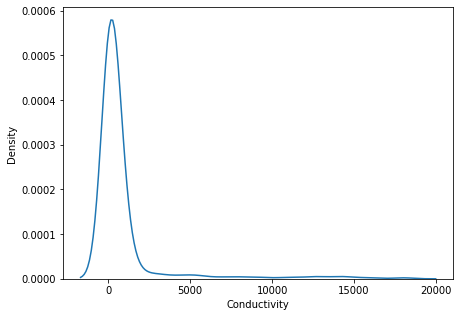

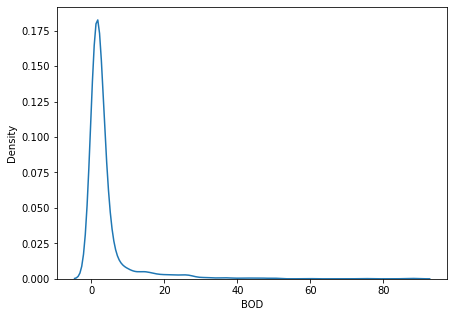

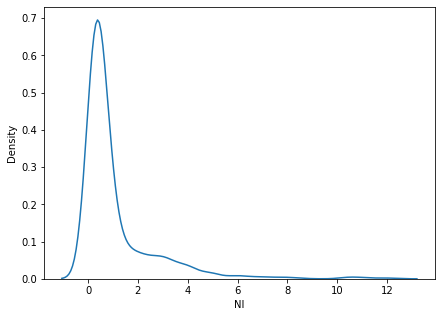

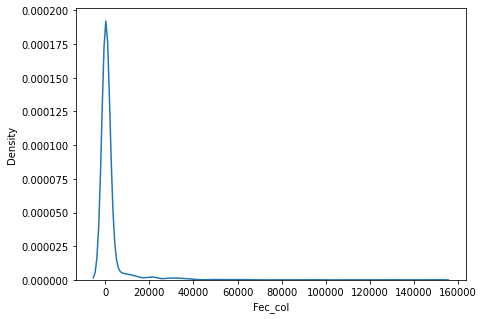

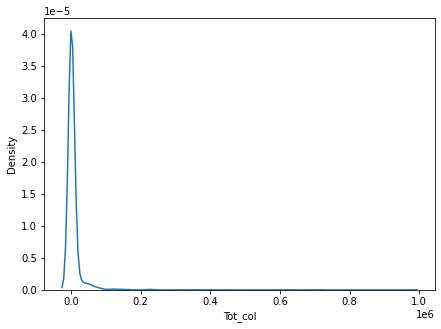

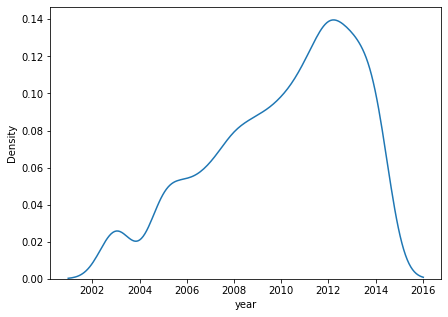

In [480]:
# KDE plots after removal of outliers
plot_kde(df_final.select_dtypes(exclude="object"))

In [481]:
# Calculating Water Quality Index of each sample
df_num_final = df_final.select_dtypes(exclude="object")
# Dropping year and Temp attribute because they are not used for computing WQI
df_num_final.drop(["year", "Temp"], axis=1, inplace=True)

# Weight Vector(wi)
wi = np.array([0.2213, 0.2604, 0.0022, 0.4426, 0.0492, 0.0221, 0.0022])

# Standard values of parameters(si)
si = np.array([10, 8.5, 1000, 5, 45, 100, 1000])

# Ideal values of paramters(vIdeal)
vIdeal = np.array([14.6, 7, 0, 0, 0, 0, 0])

def calc_wqi(sample):
    wqi_sample = 0
    num_col = 7
    for index in range(num_col):
        v_index = sample[index] # Obeserved value of sample at index
        v_index_ideal = vIdeal[index] # Ideal value of obeserved value
        w_index = wi[index] # weight of corresponding parameter of obeserved value
        std_index = si[index] # Standard value recommended for obeserved value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100 # Final qi value of obeserved value
        wqi_sample += q_index*w_index
    return wqi_sample

# Calculatinf WQI

In [482]:
# Computing WQI for the whole dataset
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

In [483]:
wqi_arr = calc_wqi_for_df(df_num_final)
# Converting oridnary array to numpy array
wqi_arr = np.array(wqi_arr)
wqi_arr = np.reshape(wqi_arr, (-1, 1))

# Resetting index values of the dataframes
wqi_arr_df = pd.DataFrame(wqi_arr, columns=["WQI"]).reset_index()
df_final = df_final.reset_index()

In [484]:
# Combining dataframe of WQI and dataframe of attributes 
df_wqi = pd.concat([df_final, pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi.drop("index", axis=1, inplace=True)
df_wqi.shape

(1861, 13)

In [485]:
# Removing the samples with negative WQI
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

In [486]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: (3 if (x <= 25)  
                                        else(2 if (26<=x<=50) 
                                        else(1 if (51<=x<=75) 
                                        else 0))))

In [487]:
df_wqi

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,1.9,0.100,11.000,27.0,2014.0,63.809303,1
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.200,4953.000,8391.0,2014.0,175.363506,0
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.100,3243.000,5330.0,2014.0,126.135831,0
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.500,5382.000,8443.0,2014.0,195.105659,0
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.400,3428.000,5500.0,2014.0,141.393246,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,28.0,7.0,136.0,7.5,1.4,0.609,0.609,205.0,2003.0,2288.522202,0
1857,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,7.9,738.0,7.2,2.7,0.518,0.518,202.0,2003.0,12746.407333,0
1858,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,29.0,7.5,585.0,6.3,2.6,0.155,0.155,315.0,2003.0,10091.343432,0
1859,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,7.6,98.0,6.2,1.2,0.516,221.000,570.0,2003.0,1629.125767,0


In [488]:
df_wqi['WQI clf'].value_counts()

0    876
1    691
2    286
3      3
Name: WQI clf, dtype: int64

# Independent variable and dependent variable

In [489]:
df_wqi.head()

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,1.9,0.1,11.0,27.0,2014.0,63.809303,1
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.2,4953.0,8391.0,2014.0,175.363506,0
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0,2014.0,126.135831,0
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0,2014.0,195.105659,0
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0,2014.0,141.393246,0


In [490]:
df_wqi=df_wqi.drop(columns=['WQI'],axis=3)
y=df_wqi['WQI clf']
x=df_wqi.drop('WQI clf',axis=1)

In [491]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: WQI clf, dtype: int64

In [492]:
x

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,1.9,0.100,11.000,27.0,2014.0
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.200,4953.000,8391.0,2014.0
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.100,3243.000,5330.0,2014.0
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.500,5382.000,8443.0,2014.0
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.400,3428.000,5500.0,2014.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1856,1329,"TAMBIRAPARANI AT RAIL BDG. NR. AMBASAMUDAM, TA...",TAMILNADU,28.0,7.0,136.0,7.5,1.4,0.609,0.609,205.0,2003.0
1857,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,7.9,738.0,7.2,2.7,0.518,0.518,202.0,2003.0
1858,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,29.0,7.5,585.0,6.3,2.6,0.155,0.155,315.0,2003.0
1859,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,7.6,98.0,6.2,1.2,0.516,221.000,570.0,2003.0


In [493]:
x.drop(x.columns[[0,1,2]],axis=1,inplace=True)

In [494]:
x.head()

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
0,30.6,6.7,7.5,203.0,1.9,0.1,11.0,27.0,2014.0
1,29.8,5.7,7.2,189.0,2.0,0.2,4953.0,8391.0,2014.0
2,29.5,6.3,6.9,179.0,1.7,0.1,3243.0,5330.0,2014.0
3,29.7,5.8,6.9,64.0,3.8,0.5,5382.0,8443.0,2014.0
4,29.5,5.8,7.3,83.0,1.9,0.4,3428.0,5500.0,2014.0


# Splitting of Train and Test data

In [495]:
# Splitting the dataset into training and test set.  
from sklearn.model_selection import train_test_split  
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25, random_state=2)  

In [497]:
from sklearn.preprocessing import StandardScaler
st_x= StandardScaler()
x_train= st_x.fit_transform(x_train)
x_test= st_x.transform(x_test)

In [498]:
#Fitting Decision Tree classifier to the training set  
from sklearn.ensemble import RandomForestClassifier  
classifier= RandomForestClassifier(n_estimators= 10, criterion="entropy")
classifier.fit(x_train, y_train)  

RandomForestClassifier(criterion='entropy', n_estimators=10)

Accuracy score of train

In [499]:
train_acc=classifier.predict(x_train)
accuracy_score(train_acc,y_train)

0.9964080459770115

In [500]:
#Predicting the test set result  
y_pred= classifier.predict(x_test)  

In [501]:
y_pred

array([0, 2, 1, 0, 1, 2, 0, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1, 1, 2, 2, 0, 0,
       0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 2, 0, 1, 2,
       1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 2, 1, 1, 2, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 2, 1, 2, 0, 0, 2,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 1, 1, 2, 1,
       1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 1, 0, 0, 0, 1, 0, 1, 0, 2, 1, 0, 1,
       0, 0, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2,
       1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 0, 1, 1, 2,
       1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 2, 1, 1,
       0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 2, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0, 2,

In [502]:
#Creating the Confusion matrix  
from sklearn.metrics import confusion_matrix  
cm= confusion_matrix(y_test, y_pred) 


Confusion Matrix

In [503]:
cm

array([[195,  17,   2,   0],
       [  8, 162,   2,   0],
       [  1,   9,  66,   0],
       [  0,   0,   2,   0]])

Accuracy of Test

In [504]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_test, y_pred)

0.9116379310344828

Prediction of WQI 

In [506]:
pred=(29.6,5.7,7.2,189.0,2.0,0.2,4953.0, 8391.0, 2014)
data=np.asarray(pred)
reshape_d=data.reshape(1,-1)
std=st_x.fit_transform(reshape_d)
p=classifier.predict(std)
if(p==0):{
    print("Thw water quality is Very Bad")
}
if(p==1):{
    print("Thw water quality is Poor ")
}
if(p==2):{
    print("The water quality is Good")
}
if(p==3):{
    print("The water quality is Excellent")
}

Thw water quality is Very Bad
